In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

## Context Isolation: Sub-agents

<img src="./assets/agent_header_subagent.png" width="800" style="display:block; margin-left:0;">

Agent context can grow quickly as conversations progress, leading to several long context-related problems. A primary issue is context clash or confusion, where mixed objectives within the same context window can lead to suboptimal performance. [Context isolation](https://blog.langchain.com/context-engineering-for-agents/) provides an effective solution by delegating tasks to [specialized sub-agents](https://www.anthropic.com/engineering/multi-agent-research-system), each operating within their own isolated context window. This approach prevents context clashes, confusion, poisoning, and dilution while enabling focused, specialized task execution.



### Sub-agent delegation
![./assets/subagents.png](./assets/subagents.png)

The primary insight is that we can create sub-agents with different tool sets tailored to specific tasks. Each sub-agent is stored in a registry dictionary with `subagent_type` as the key, allowing the main agent to delegate work through a `task(description, subagent_type)` tool call. The sub-agent operates in complete isolation from the parent's context, and its results are returned as a `ToolMessage` to the parent agent, maintaining clean separation of concerns.

<div style="background-color: #fff3b0; padding: 10px; border-radius: 4px;">
<b>Note:</b>  
The <code>create_react_agent</code> was moved from the LangGraph library to the LangChain library and renamed to <code>create_agent</code> in the 1.0 code release post-filming. There are slight changes to the imports and code to accommodate this. The video may display the previous configuration.
</div>

## Step 1: Create Sub Agents

Let's define how the user will specify sub agents
```python
from typing_extensions import TypedDict

class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]
```

We will use a list of these objects to create all the sub agents we have access to

```python
agents: list[SubAgent] = ...
subagents = {
    agent['name']: create_react_agent(
        model=model,
        prompt=agent['prompt'],
        tools = get_tools(agent['tools']),
        ...
    )
}
```

## Step 2: Create a tool to use Sub Agents

Logically, should look something like:

```python
def task(
    description: str  # The task the subagent should do
    subagent_type: str  # Which subagent to use
):
    # Create new messages to pass to subagent - should just be the description
    # Call sub agent
    # Update state with both the subagents response AND any changes to file system
```

This ends up in full looking like:

```python
@tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
def task(
    description: str,
    subagent_type: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """Delegate a task to a specialized sub-agent with isolated context.

    This creates a fresh context for the sub-agent containing only the task description,
    preventing context pollution from the parent agent's conversation history.
    """
    # Validate requested agent type exists
    if subagent_type not in agents:
        return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

    # Get the requested sub-agent
    sub_agent = agents[subagent_type]

    # Create isolated context with only the task description
    # This is the key to context isolation - no parent history
    state["messages"] = [{"role": "user", "content": description}]

    # Execute the sub-agent in isolation
    result = sub_agent.invoke(state)

    # Return results to parent agent via Command state update
    return Command(
        update={
            "files": result.get("files", {}),  # Merge any file changes
            "messages": [
                # Sub-agent result becomes a ToolMessage in parent context
                ToolMessage(
                    result["messages"][-1].content, tool_call_id=tool_call_id
                )
            ],
        }
    )

return task
```

In [5]:
%%writefile src/deepAgents/task_tool.py
"""Task delegation tools for context isolation through sub-agents.

This module provides the core infrastructure for creating and managing sub-agents
with isolated contexts. Sub-agents prevent context clash by operating with clean
context windows containing only their specific task description.
"""

from typing import Annotated, NotRequired
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState  # updated 1.0
from langchain.agents import create_agent  # updated 1.0

from langgraph.types import Command

from src.deepAgentsprompts import TASK_DESCRIPTION_PREFIX
from src.deepAgentsstate import DeepAgentState


class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagents: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """
    # Create agent registry
    agents = {}

    # Build tool name mapping for selective tool assignment
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    # Create specialized sub-agents based on configurations
    for _agent in subagents:
        if "tools" in _agent:
            # Use specific tools if specified
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # Default to all tools
            _tools = tools
        agents[_agent["name"]] = create_agent(   # updated 1.0
            model, system_prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
        )

    # Generate description of available sub-agents for the tool description
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]

    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        # Validate requested agent type exists
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # Get the requested sub-agent
        sub_agent = agents[subagent_type]

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": description}]

        # Execute the sub-agent in isolation
        result = sub_agent.invoke(state)

        # Return results to parent agent via Command state update
        return Command(
            update={
                "files": result.get("files", {}),  # Merge any file changes
                "messages": [
                    # Sub-agent result becomes a ToolMessage in parent context
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

Overwriting src/deepAgents/task_tool.py


Now, you have a routine that will generate sub-agents as tools. Now, you can define specific sub-agents and allow the system to call them with the `task` tool.    
Above, the `_create_task_tool` receives a list of type `SubAgent`. This list contains descriptions of the agents that are to be created. 

```python
class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

```
The `SubAgent` class defines the unique information needed to satisfy the dual role of a sub-agent. Sub-agents act as both tools and agents.  

- **As tools**, they provide the supervisor agent with information about their capabilities and how they can be called.  
- **As agents**, they require a prompt that describes how to carry out their tasks, along with a set of tools targeted for those tasks.  

Below, you will create a research subagent. Its `description` informs the supervisor agent that a single task should be delegated to this sub-agent. The `SIMPLE_RESEARCH_INSTRUCTIONS` is a prompt that is used by the sub-agent to direct its research. In this example, it is brief, but for a general-purpose researcher, it could be much more detailed. The sub-agent is also supplied with a `web_search` tool to use during its research.  

```python
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}
```

Note that the sub-agent receives a specific task, along with the necessary tools to complete it. It operates in its own context, limited to the single task description. This [context-engineering](https://blog.langchain.com/context-engineering-for-agents/) approach ensures that the subagent’s working context remains free of context clashes, confusion, poisoning, and dilution.

The supervisor agent prompt must now include a descripition of how to invoke and use these sub-agents. This is shown below. Note the *Available Tools* description and the instructions to use parallel research where applicable.

In [6]:
from utils import show_prompt

from src.deepAgents.prompts import SUBAGENT_USAGE_INSTRUCTIONS

show_prompt(SUBAGENT_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element 

Let's now build a research system with a supervisor and sub-agents. This will just be a mock-up version with pre-defined search results to demonstrate how the pieces go together. In the next lesson, you will build a full-fledged research system.

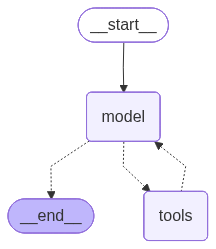

In [9]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
#from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent # updated in 1.0

from src.deepAgents.prompts import SUBAGENT_USAGE_INSTRUCTIONS
from src.deepAgents.state import DeepAgentState
from src.deepAgents.task_tool import _create_task_tool

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Tools for sub-agent
sub_agent_tools = [web_search]

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# Tools
delegation_tools = [task_tool]

# Create agent with system prompt
agent = create_agent(
    model,
    delegation_tools,
    system_prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %-d, %Y"),
    ),
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [10]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll research the Model Context Protocol (MCP) for you to provide a comprehensive overview.                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research the Model Context Protocol (MCP) - what it is, its purpose, key features, how it     │
│ works, who developed it, current adoption status, and its significance in the AI/ML ecosystem. Include          │
│ technical details about its architecture and implementation.",                                                  │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01AruB8JR7HBRwajYM2kYPQj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is the Model Context Protocol (MCP)?                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard protocol developed by **Anthropic** that serves as a       │
│ standardized communication layer between AI models and external systems. It enables seamless integration        │
│ between AI assistants and various external services including tools, databases, APIs, and other data sources.   │
│                                                                                                                 │
│ ## Purpose and Significance                                                                                     │
│                                                                                                                 │
│ **Primary Purpose:**                                                                                            │
│ - Simplify the process of connecting AI assistants to external services                                         │
│ - Provide a unified language for data exchange between AI models and external systems                           │
│ - Eliminate the need for custom integrations for each external service                                          │
│ - Enable AI models to access and utilize data from various sources consistently                                 │
│                                                                                                                 │
│ **Significance in AI/ML Ecosystem:**                                                                            │
│ - **Standardization**: Creates a common protocol that reduces fragmentation in AI tool integration              │
│ - **Scalability**: Allows AI systems to easily connect to multiple external services without custom development │
│ - **Interoperability**: Enables different AI models and services to work together more effectively              │
│ - **Developer Efficiency**: Reduces development time and complexity for AI application builders                 │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ 1. **Unified Communication Layer**: Provides a consistent interface for AI-external system communication        │
│ 2. **Open Standard**: Being open-source promotes widespread adoption and community contribution                 │
│ 3. **Tool Integration**: Seamlessly connects AI models to various tools and services                            │
│ 4. **Database Connectivity**: Enables direct access to databases and data repositories                          │
│ 5. **API Standardization**: Creates consistent patterns for API interactions                                    │
│ 6. **Cross-Platform Compatibility**: Works across different AI models and platforms                             │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ **Core Components:**                                   

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open standard protocol developed by **Anthropic** that creates a     │
│ standardized communication layer between AI models and external systems. It serves as a universal interface     │
│ that enables AI assistants to seamlessly connect with tools, databases, APIs, and other data sources.           │
│                                                                                                                 │
│ ## Key Purpose & Benefits                                                                                       │
│                                                                                                                 │
│ **Primary Goals:**                                                                                              │
│ - **Standardization**: Eliminates the need for custom integrations for each external service                    │
│ - **Simplification**: Provides a unified language for data exchange between AI models and external systems      │
│ - **Scalability**: Allows AI systems to easily connect to multiple services without custom development          │
│ - **Interoperability**: Enables different AI models and services to work together effectively                   │
│                                                                                                                 │
│ ## Core Features                                                                                                │
│                                                                                                                 │
│ 1. **Unified Communication Layer** - Consistent interface for all AI-external system interactions               │
│ 2. **Open Standard** - Open-source approach promoting widespread adoption                                       │
│ 3. **Cross-Platform Compatibility** - Works across different AI models and platforms                            │
│ 4. **Tool Integration** - Seamless connection to various tools and services                                     │
│ 5. **Database Connectivity** - Direct access to databases and data repositories                                 │
│ 6. **Standardized API Patterns** - Consistent interaction methods across service types                          │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ **Key Components:**                                                                                             │
│ - **Protocol Layer**: Defines communication standards and message formats                                       │
│ - **Integration Interface**: Standardized methods for connecting external services                              │
│ - **Data Exchange Format**: Structured information transmission protocols                                       │
│ - **Security Layer**: Handles authentication and secure connections                                             │
│                                                                                                                 │
│ **How It Works:**                                      

Trace: 
https://smith.langchain.com/public/26cc1c2b-e785-4c6d-a2a7-c30a31875fc7/r
<!-- https://smith.langchain.com/public/edc4e672-db9c-457a-953d-f62e7813591c/r -->